In [1]:
from torchvision.datasets import MNIST 
import numpy as np 
from pytorch_ood.utils import fix_random_seed

fix_random_seed(123)

ds = MNIST("data", download=True, train=True)
labels = ds.targets
imgs = ds.train_data
imgs.shape

d = {}

for i in np.unique(labels):
    d[i] = imgs[labels == i]
    

/home/kirchhei/.local/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [2]:
import random
import torch 

def constrained_sum_sample_pos(n, total):
    """Return a randomly chosen list of n positive integers summing to total.
    Each such list is equally likely to occur."""

    dividers = sorted(random.sample(range(0, total), n - 1))
    return [a - b for a, b in zip(dividers + [total], [0] + dividers)]

def get_limits(img):
    x_min = img.sum(dim=0).cumsum(dim=0).diff().nonzero().min().relu().item()
    x_max = img.sum(dim=0).cumsum(dim=0).diff().nonzero().max().relu().item() + 2

    y_min = img.sum(dim=1).cumsum(dim=0).diff().nonzero().min().relu().item() 
    y_max = img.sum(dim=1).cumsum(dim=0).diff().nonzero().max().relu().item() + 2
    return x_min, x_max, y_min, y_max


def generate(total=20):
    nums = [11]
    while max(nums) >= 10:
        nums = constrained_sum_sample_pos(4, total)
    
    nums = np.random.permutation(nums)
    tmp = torch.empty((56,56))
    
    img1 = d[nums[0]][np.random.randint(0, len(d[nums[0]]))]
    tmp[0:28,0:28] = img1
    l1_xmin, l1_xmax, l1_ymin, l1_ymax = get_limits(img1)
    l1 = (l1_xmin, l1_xmax, l1_ymin, l1_ymax)
    
    img2 = d[nums[1]][np.random.randint(0, len(d[nums[1]]))]
    tmp[28:56,0:28] = img2
    l2_xmin, l2_xmax, l2_ymin, l2_ymax = get_limits(img2)
    l2 = (l2_xmin, l2_xmax, l2_ymin + 28, l2_ymax + 28)
    
    img3 = d[nums[2]][np.random.randint(0, len(d[nums[2]]))]
    tmp[0:28,28:56] = img3
    l3_xmin, l3_xmax, l3_ymin, l3_ymax = get_limits(img3)
    l3 = (l3_xmin  + 28, l3_xmax  + 28, l3_ymin, l3_ymax)
    
    img4 = d[nums[3]][np.random.randint(0, len(d[nums[3]]))]
    tmp[28:56,28:56] = img4
    l4_xmin, l4_xmax, l4_ymin, l4_ymax = get_limits(img4)
    l4 = (l4_xmin + 28, l4_xmax + 28, l4_ymin + 28, l4_ymax + 28)
    
    return tmp, nums, np.array([l1, l2, l3, l4])

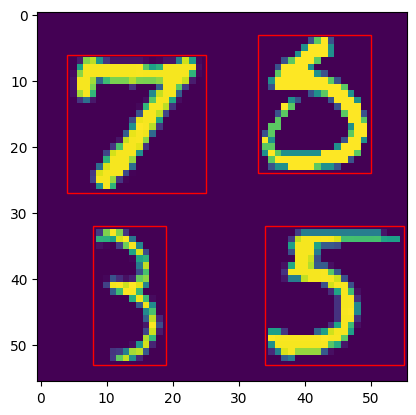

In [3]:
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle


img, nums, boxes = generate()

fig, ax = plt.subplots()

ax.imshow(img)

for box in boxes:
    x_min, x_max, y_min, y_max = box 
    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


In [4]:
import torch 


imgs = []
labels = []
boxes = []

for i in range(60000):
    tmp = torch.zeros(size=(56,56))
    tmp, nums, b = generate(total=20)
    imgs.append(tmp.numpy())
    labels.append(nums)
    boxes.append(b)

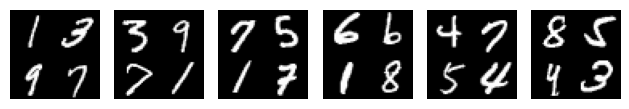

In [5]:
t = 5
fig, ax = plt.subplots(1,t+1)

ax = ax.flatten()

start_i = 110

for i, n in enumerate(np.random.permutation(range(start_i, start_i+t+1))):
    if i == 3:
        ax[i].imshow(generate(21)[0], cmap="gray")
        ax[i].axis('off')
    else:
        ax[i].imshow(imgs[n], cmap="gray")
        ax[i].axis('off')
    
# add some unknown example 
# d = np.load("x-test.npz")
# data = d["arr_0"]

plt.axis('off')
plt.tight_layout()
plt.savefig("mnist-example.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [6]:
labels = np.array(labels)
imgs = np.array(imgs)

In [7]:
np.savez("sumnist/y-train.npz", labels)
np.savez("sumnist/x-train.npz", imgs)
np.savez("sumnist/b-train.npz", boxes)

In [8]:
ds = MNIST("data", download=True, train=False)
labels = ds.targets
imgs = ds.train_data
imgs.shape

d = {}

for i in np.unique(labels):
    d[i] = imgs[labels == i]

/home/kirchhei/.local/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [9]:
imgs = []
labels = []
boxes = []

for i in range(8500):
    tmp = torch.zeros(size=(56,56))
    tmp, nums, b = generate()
    imgs.append(tmp.numpy())
    labels.append(nums)
    boxes.append(b)

In [10]:
        
for i in [10,11,12,13,14,15,16,17,18,19,21,22,23,24,25]:
    print(i)
    for _ in range(100):
        tmp = torch.zeros(size=(56,56))
        tmp, nums, b = generate(i)
        imgs.append(tmp.numpy())
        labels.append(nums)
        boxes.append(b)

10
11
12
13
14
15
16
17
18
19
21
22
23
24
25


In [11]:
len(labels)

10000

In [12]:
np.savez("sumnist/y-test.npz", labels)
np.savez("sumnist/x-test.npz", imgs)
np.savez("sumnist/b-test.npz", boxes)

# Visualizations 

In [13]:
import numpy as np 
import torch 

with np.load("sumnist/x-test.npz") as data:
    x_test = torch.tensor(data['arr_0'])

with np.load("sumnist/y-train.npz") as data:
    y_train = torch.tensor(data['arr_0'])
    
with np.load("sumnist/x-train.npz") as data:
    x_train = torch.tensor(data['arr_0'])
    
with np.load("sumnist/y-test.npz") as data:
    y_test = torch.tensor(data['arr_0'])

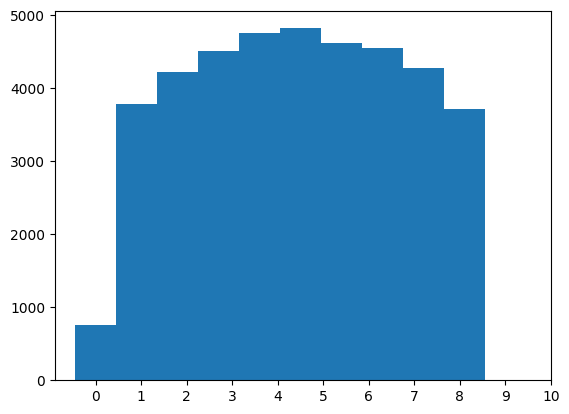

In [14]:
import matplotlib.pyplot as plt 

plt.hist(y_test.flatten().numpy(), bins=10, align="left")
_ = plt.xticks(range(11))

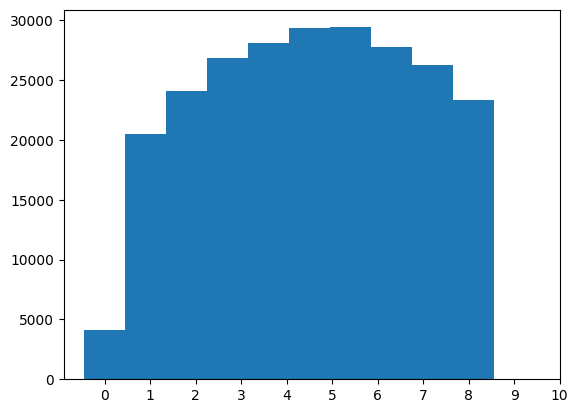

In [15]:
plt.hist(y_train.flatten().numpy(), bins=10, align="left")
_ = plt.xticks(range(11))